In [43]:
using MPSTime
using Random
using Plots
using PrettyTables
using DSP
using Statistics
using Serialization
using ITensors
using Colors, ColorSchemes

# Random.seed!(1234);

In [44]:
# using Distributed
# e = copy(ENV)
# e["JULIA_NUM_THREADS"] = "1"
# e["OMP_NUM_THREADS"] = "1"
# addprocs(1; env=e)
# @everywhere using MPSTime, Random, Statistics, ITensors, Serialization

In [45]:
# workers()

In [46]:
macro noprint(expr)
    quote
        let so = stdout
            redirect_stdout(devnull)
            res = $(esc(expr))
            redirect_stdout(so)
            res
        end
    end
end;

In [47]:
function create_overlapping_windows(time_series::Array{Float64, 2}, ntimepoints::Int64)
    nsamples = length(time_series) - ntimepoints + 1
    time_series_windows = Array{Float64, 2}(undef, ntimepoints, nsamples)
    for i in 1:nsamples
        time_series_windows[:,i] = time_series[i:i+ntimepoints-1]
    end
    return time_series_windows
end;

In [48]:
function generate_ar_data(ts_length::Int; phi::Union{<:Number,AbstractVector{<:Number}} = 0.5, sigma::Number = 0.0)
    if typeof(phi) == Float64
        phi = [phi]
    end

    p = length(phi)
    time_series = Array{Float64, 2}(undef, 1, ts_length)
    time_series[1, 1:p] = randn(p) .* sigma .+ rand([-1, 1], p) .* eps()
    
    for t in (p+1):ts_length
        time_series[1, t] = sum(phi .* time_series[t-p:t-1]) + sigma * randn()
    end
    
    return time_series;
end;

In [49]:
function generate_time_series(ts_params::Dict)

    ts_type = ts_params[:ts_type]
    ts_length = ts_params[:ts_length]

    time_series = Array{Float64, 2}(undef, 1, ts_length)

    if ts_type == :sine
        time_series = generate_sinusoidal(ts_length; freq = ts_params[:s_freq],
                                        amp = ts_params[:s_amp],
                                        phase = ts_params[:s_phase],
                                        sigma = ts_params[:s_sigma])
        
    elseif ts_type == :ar
        time_series = generate_ar_data(ts_length; phi = ts_params[:ar_phi],
                                        sigma = ts_params[:ar_sigma])

    elseif ts_type == :lm
        time_series = generate_logistic_map(ts_length; r = ts_params[:lm_r],
                                        x0 = ts_params[:lm_x0])

    else
        error("Invalid method. Choose :sine (Sinusoidal), :l_m (Logistic Map), :ar (AR(n))")
    end

    ts_wndw = create_overlapping_windows(time_series, ts_params[:mps_N])

    ts_train_wndw, ts_test_wndw = train_test_split(ts_wndw; split_ratio = ts_params[:ts_split])

    return (ts_train_wndw, ts_test_wndw)
end;

In [50]:
function train_test_split(time_series::Array{Float64, 2}; split_ratio::Union{Nothing, Float64}=nothing, test_length::Union{Nothing, Integer}=nothing)
    nsamples = size(time_series, 2)
    
    # Validate inputs
    if split_ratio === nothing && test_length === nothing
        error("Either split_ratio or test_length must be provided")
    elseif split_ratio !== nothing && test_length !== nothing
        error("Only one of split_ratio or test_length should be provided")
    elseif split_ratio !== nothing && (split_ratio <= 0 || split_ratio >= 1)
        error("split_ratio must be between 0 and 1")
    elseif test_length !== nothing && (test_length <= 0 || test_length >= nsamples)
        error("test_length must be between 1 and $(nsamples-1)")
    end

    if split_ratio !== nothing
        split_idx = Int(floor(nsamples * split_ratio))
    else
        split_idx = nsamples - test_length
    end
    
    if split_idx <= 0 || split_idx >= nsamples
        error("Calculated split index is out of bounds. Adjust your parameters.")
    end
    
    train_data = time_series[:, 1:split_idx]
    test_data = time_series[:, split_idx+1:end]
    
    return (train_data, test_data)
end;

In [51]:
function plot_windowed_data(windowed_data::Array{Float64, 2})
    
    ntimepoints = size(windowed_data, 1)
    nsamples = size(windowed_data, 2)

    p = plot()
    
    for sample = 1:nsamples

        x_vals = sample:(sample + ntimepoints - 1)

        plot!(x_vals, windowed_data[:, sample], label="", lw=2, linecolor = :red)

    end

    return p
    
end;

In [52]:
function train_MPS(time_series::Array{Float64, 2}, ts_params::Dict)

    opts = MPSOptions(d = ts_params[:mps_d], chi_max = ts_params[:mps_chi], nsweeps = ts_params[:mps_sweeps], sigmoid_transform = false)
    # println("Begun training")
    mps, info, _ = @noprint fitMPS(time_series, opts)
    # println(info)

    return mps, info
end;

In [53]:
function make_prediction(window::Array{Float64,2}, mps, ts_params::Dict)

    class = 0
    instance_idx = 1
    impute_sites = [ts_params[:mps_N]]
    method = :median
    rng = Xoshiro(1)
    x = collect(-1:1e-4:1)

    # imp = @noprint MPSTime.init_imputation_problem_simple(mps, Matrix(transpose(window)); verbosity = -1, x_vector = x)
    imp = @noprint MPSTime.init_imputation_problem(mps, Matrix(transpose(window)))

    nxt_stp, prd_err, _, _, _ = @noprint MPS_impute(imp, class, instance_idx, impute_sites, method)

    return (nxt_stp, prd_err)
end;

In [54]:
function ts_minmax(time_series::Array{Float64, 2})
    ts_min, ts_max = minimum(time_series), maximum(time_series)

    ts_minmax = Array{Float64, 2}(undef, 1, length(time_series))

    ts_minmax[1,:] = (time_series .- ts_min) ./ (ts_max - ts_min)

    return ts_minmax
end;

In [55]:
function ts_zscore(time_series::Array{Float64, 2})
    ts_mean, ts_stderr = mean(time_series), std(time_series)

    ts_zscore = Array{Float64, 2}(undef, 1, length(time_series))

    ts_zscore[1,:] = (time_series .- ts_mean) ./ (ts_stderr)

    return ts_zscore
end;

In [56]:
function ts_zscore_capped_minmax(time_series::Array{Float64, 2}, X::Float64)
    # z-score + capping
    ts_mean, ts_stderr = mean(time_series), std(time_series)
    zscores = clamp.((time_series .- ts_mean) ./ ts_stderr, -X, X)
    
    # minmax scaling
    ts_min, ts_max = minimum(zscores), maximum(zscores)
    return 2 .* (zscores .- ts_min) ./ (ts_max - ts_min) .- 1
end;

In [64]:
function evaluate_model(test_data, mps, ts_params, ts_min, ts_max)
    # Initialize parameters
    window_size = ts_params[:mps_N]
    total_points = size(test_data, 2)
    
    # We start predicting from the 3rd point (index 3 in 1-based indexing)
    # First prediction uses points 1-2 to predict point 3
    first_prediction_idx = ts_params[:mps_N]
    num_predictions = total_points - first_prediction_idx + 1
    
    # Pre-allocate results
    predicted_values = Vector{Float64}(undef, total_points)
    actual_values = copy(test_data[1, :])  # Copy all true values
    prediction_errors = Vector{Float64}(undef, total_points)
    mean_pred_values = Vector{Float64}(undef, total_points)
    ar_pred_values = Vector{Float64}(undef, total_points)
    
    # Initialize the first two points (no predictions yet)
    predicted_values[1:ts_params[:mps_N] - 1] = actual_values[1:ts_params[:mps_N] - 1]
    prediction_errors[1:ts_params[:mps_N] - 1] .= 0.0
    mean_pred_values[1:ts_params[:mps_N] - 1] = actual_values[1:ts_params[:mps_N] - 1]
    ar_pred_values[1:ts_params[:mps_N] - 1] = actual_values[1:ts_params[:mps_N] - 1]
    
    # Initialize metrics
    model_mse = 0.0
    model_mae = 0.0
    mean_mse = 0.0
    
    for i in first_prediction_idx:total_points
        # The window is the previous (window_size) points
        window = test_data[:, i:i]
        true_value = actual_values[i]

        window = min.(max.(window, ts_min), ts_max)
        
        # Model prediction
        nxt_stp, prd_err = make_prediction(window, mps, ts_params)
        # println(nxt_stp)
        pred_value = nxt_stp[1][end]

        if pred_value < ts_min
            pred_value = ts_min
        elseif pred_value > ts_max
            pred_value = ts_max
        end

        
        # Simple mean baseline (using all available history)
        mean_pred = mean(actual_values[max(1,i - ts_params[:mps_N] - 1):i-1])
        # println(ts_params[:ar_phi])
        ar_noiseless_pred = window[ts_params[:mps_N]-1] * ts_params[:ar_phi]
        
        # Store results
        predicted_values[i] = pred_value
        prediction_errors[i] = prd_err[1][end]
        mean_pred_values[i] = mean_pred
        ar_pred_values[i] = ar_noiseless_pred
        
        # Only accumulate metrics if we have both prediction and true value
        if i <= total_points
            model_mse += (pred_value - true_value)^2
            model_mae += abs(pred_value - true_value)
            mean_mse += (mean_pred - true_value)^2
        end
        
        # # Progress tracking
        # if (i - first_prediction_idx + 1) % 10 == 0
        #     println("Predicting point $i: Pred = $(round(pred_value, digits=4)), True = $(round(true_value, digits=4))")
        # end
    end
    
    # Finalize metrics (only count actual predictions made)
    num_actual_predictions = total_points - first_prediction_idx + 1
    model_mse /= num_actual_predictions
    model_mae /= num_actual_predictions
    mean_mse /= num_actual_predictions

    return (
        time_points = 1:total_points,
        predicted = predicted_values,       # First 2 points = actual, then predictions
        actual = actual_values,             # All true values
        mps_prderr = prediction_errors,         # Zeros for first 2 points
        mean_predictions = mean_pred_values,
        ar_predictions = ar_pred_values,
        metrics = (
            model_mse = model_mse,
            model_mae = model_mae,
            mean_mse = mean_mse,
            first_prediction_idx = first_prediction_idx
        )
    )
end;

In [65]:
ts_params = Dict(
    :ts_type => :ar,
    :ts_length => 4000,
    :ts_test_length => 200,
    :ts_split => nothing,
    # :ts_preprocess => :diff, :zscore, :minmax,
    :ts_norm_cap => 3.0,
    
    :mps_N => 4,
    :mps_d => 15,
    :mps_chi => 100,
    :mps_sweeps => 50,

    # Sine Related Metrics
    :s_freq => 0.005,
    :s_amp => 1.0,
    :s_phase => 0.0,
    :s_sigma => 0.0,

    #AR(n) Related Metrics
    :ar_phi => [0.0],
    :ar_phi_range => [-0.99, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 0.99 ],
    # :ar_phi => [1.0,0.0],
    :ar_sigma => 1,

    #Logistic Map Related Metrics
    :lm_r => 4,
    :lm_x0 => 0.2

);

In [ ]:
# pmap(x-> begin
results = []
all_outputs = Dict{Tuple{Float64, Int}, NamedTuple}()

train_lengths = [1, 2, 3, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000]

for (i, phi) in enumerate(ts_params[:ar_phi_range])
    println("\nTesting ar_phi = $phi")
    ts_params[:ar_phi] = phi
    
    # Generate full time series
    full_series = generate_ar_data(ts_params[:ts_length]; phi=phi, sigma=ts_params[:ar_sigma])

    norm_full_ts = ts_zscore_capped_minmax(full_series, ts_params[:ts_norm_cap])
    
    # Create windows from full series
    full_data = create_overlapping_windows(norm_full_ts, ts_params[:mps_N])
    
    for train_length in train_lengths
        println("  Training length: $train_length")
        Random.seed!(1234)
        
        # Calculate split index (must be integer)
        split_idx = size(full_data, 2) - ts_params[:ts_test_length]
        
        # Ensure we don't exceed array bounds
        actual_train_length = min(train_length, split_idx)
        if actual_train_length != train_length
            println("  Adjusted training length from $train_length to $actual_train_length to fit data")
        end
        
        # Get training data (most recent samples within bounds)
        train_start = max(1, split_idx - actual_train_length + 1)
        train = full_data[:, train_start:split_idx]
        test = full_data[:, split_idx+1:end]
        
        # Verify sizes
        @assert size(test, 2) == ts_params[:ts_test_length] "Test set size mismatch"
        
        # Normalize using only training data
        # train_min = minimum(train)
        # train_max = maximum(train)

        train_min = -1
        train_max = 1
        
        # Train model
        mps, info = train_MPS(Matrix(transpose(train)), ts_params)
        
        # Evaluate model
        output = evaluate_model(test, mps, ts_params, train_min, train_max)
        metrics = output.metrics
        
        # Save summary metrics
        push!(results, (
            ar_phi = phi,
            train_length = actual_train_length,
            test_length = ts_params[:ts_test_length],
            model_mse = metrics.model_mse,
            model_mae = metrics.model_mae,
            mean_mse = metrics.mean_mse
        ))
        
        # Save full output
        full_output = merge(output, (ts_params = deepcopy(ts_params),))
        all_outputs[(phi, actual_train_length)] = full_output
    end
end
# end, [1])

# # Save to file
open("xxxy_T_phis_sigma=1.jls", "w") do io
    serialize(io, all_outputs)
end


Testing ar_phi = -0.99
  Training length: 1
  Training length: 2
  Training length: 3
  Training length: 5
  Training length: 10
  Training length: 25
  Training length: 50
  Training length: 75
  Training length: 100
  Training length: 250
  Training length: 500
  Training length: 750
  Training length: 1000
  Training length: 1500
  Training length: 2000
  Training length: 3000
  Training length: 4000
  Adjusted training length from 4000 to 3797 to fit data

Testing ar_phi = -0.75
  Training length: 1
  Training length: 2
  Training length: 3
  Training length: 5
  Training length: 10
  Training length: 25
  Training length: 50
  Training length: 75
  Training length: 100
  Training length: 250
  Training length: 500
  Training length: 750
  Training length: 1000
  Training length: 1500
  Training length: 2000
  Training length: 3000
  Training length: 4000
  Adjusted training length from 4000 to 3797 to fit data

Testing ar_phi = -0.5
  Training length: 1
  Training length: 2
  Tra

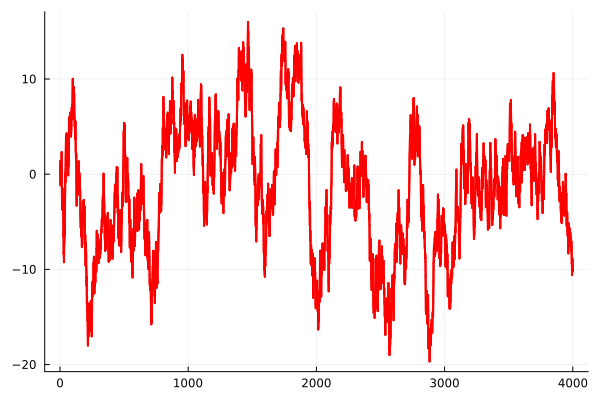

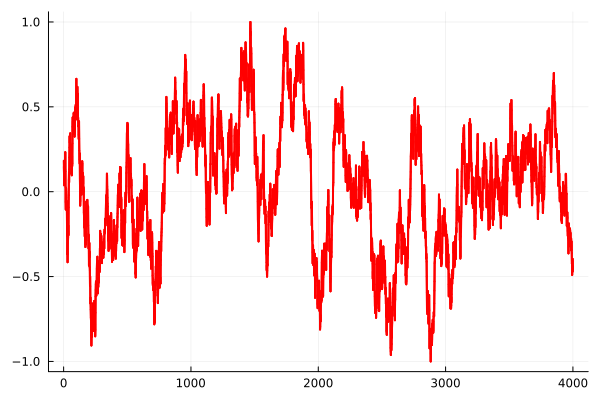

In [39]:
eg_data = generate_ar_data(ts_params[:ts_length]; phi=0.99, sigma=ts_params[:ar_sigma])
eg_data_normed = ts_zscore_capped_minmax(eg_data, ts_params[:ts_norm_cap])
p1 = plot_windowed_data(create_overlapping_windows(eg_data, ts_params[:mps_N]))
p2 = plot_windowed_data(create_overlapping_windows(eg_data_normed, ts_params[:mps_N]))
display(p1)
display(p2)

In [135]:
all_ouputs_quicker = all_outputs

Dict{Tuple{Float64, Int64}, NamedTuple} with 1 entry:
  (0.5, 100) => (time_points = 1:200, predicted = [0.0134788, 0.405511, 0.03657…

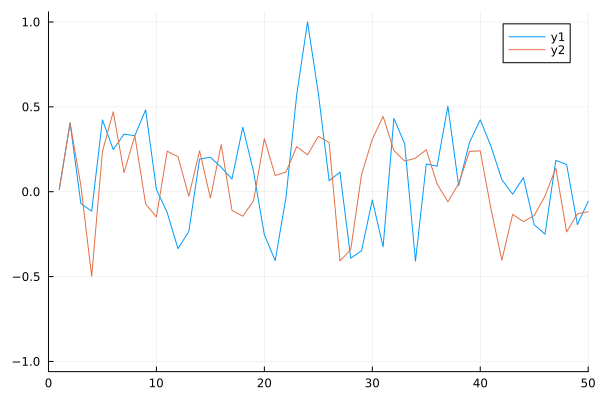

In [136]:
# plot(all_ouputs_quicker[(0.5,100)][:predicted] .- all_ouputs_quicker[(0.5,100)][:actual], xlims = [0,50])
plot(all_ouputs_quicker[(0.5,100)][:actual], xlims = [0,50])
plot!(all_ouputs_quicker[(0.5,100)][:predicted])

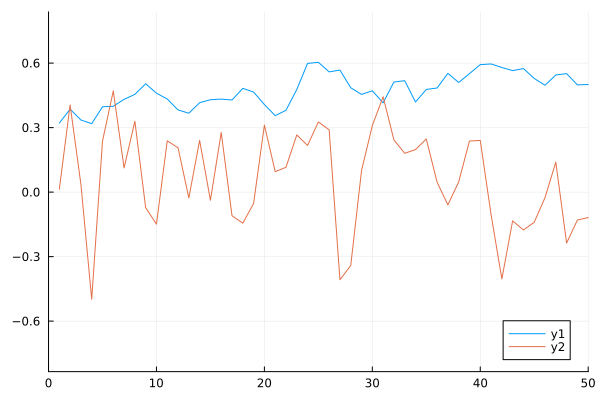

In [22]:
# plot(all_outputs[(0.5,100)][:predicted] .- all_outputs[(0.5,100)][:actual], xlims = [0,50])
plot(all_outputs[(0.99,100)][:actual], xlims = [0,50])
plot!(all_outputs[(0.5,100)][:predicted])

In [16]:
train_series = generate_ar_data(ts_params[:ts_length]; phi = 0.9, sigma = ts_params[:ar_sigma])



# time_series = ts_minmax(time_series)

train_data = create_overlapping_windows(train_series, ts_params[:mps_N])

3×3998 Matrix{Float64}:
 -1.62201  -2.32727  -2.43869  -2.81715  …  -2.27908   -0.775081  -0.801562
 -2.32727  -2.43869  -2.81715  -1.40352     -0.775081  -0.801562  -1.18121
 -2.43869  -2.81715  -1.40352  -2.49554     -0.801562  -1.18121    1.31856

In [17]:
mps, info = train_MPS(Matrix(transpose(train_data)), ts_params)

(TrainedMPS(MPS
[1] ((dim=15|id=349|"Site,n=1"), (dim=15|id=484|"Link,l=1"))
[2] ((dim=15|id=107|"Site,n=2"), (dim=15|id=484|"Link,l=1"), (dim=15|id=458|"Link,l=2"))
[3] ((dim=15|id=547|"Site,n=3"), (dim=1|id=268|"f(x)"), (dim=15|id=458|"Link,l=2"))
, MPSOptions(1, 50, 100, 0.01, 15, :Legendre, false, 2, 1.0e-10, 1, Float64, :KLD, :TSGO, false, (false, true), false, false, false, true, false, false, 1234, 4, 3, (0.0, 1.0), false, "divide_and_conquer"), EncodedTimeSeriesSet(MPSTime.PState[MPSTime.PState(Vector[[0.7071067811865476, -0.233609033620067, -0.7042816401317858, 0.5028087142766835, 0.5183617137598733, -0.7009976913865194, -0.2526732212908944, 0.7977917325009887, -0.050923124940273325, -0.7787237230548621, 0.34763557928943867, 0.6464134373812659, -0.5940739642394979, -0.42003577242022105, 0.7542684243638453], [0.7071067811865476, -0.35339783473959474, -0.593100939753331, 0.6973717490671574, 0.1975022131157112, -0.8127678667168012, 0.2696070535309398, 0.6583296763266826, -0.64894

In [18]:
typeof(mps.mps)

MPS

In [19]:
length(mps.mps)

3

In [20]:
base_mps = mps.mps  


MPS
[1] ((dim=15|id=349|"Site,n=1"), (dim=15|id=484|"Link,l=1"))
[2] ((dim=15|id=107|"Site,n=2"), (dim=15|id=484|"Link,l=1"), (dim=15|id=458|"Link,l=2"))
[3] ((dim=15|id=547|"Site,n=3"), (dim=1|id=268|"f(x)"), (dim=15|id=458|"Link,l=2"))


In [21]:
fieldnames(MPS)

(:data, :llim, :rlim)

In [22]:
typeof(mps.opts)

MPSOptions

In [23]:
methods(init_imputation_problem)

# 5 methods for generic function "init_imputation_problem" from MPSTime:
 [1] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix, custom_encoding::Encoding; kwargs...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:193
 [2] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix, y_test::AbstractVector, custom_encoding::Union{Nothing, Encoding}; test_encoding, kwargs...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:143
 [3] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix, y_test::AbstractVector; ...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:143
 [4] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix; ...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:143
 [5] init_imputation_problem(mps::MPS, X_train::AbstractMatrix{R}, y_train::AbstractVector{Int64}, X_test::AbstractMatrix{R}, y_test::AbstractVector{Int64}, opts::MPSTime.AbstractMPSOptions; verbosity, dx, guess_range, static_xvecs) where R<:Real
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:48

In [24]:
methods(MPSTime.init_imputation_problem)

# 5 methods for generic function "init_imputation_problem" from MPSTime:
 [1] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix, custom_encoding::Encoding; kwargs...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:193
 [2] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix, y_test::AbstractVector, custom_encoding::Union{Nothing, Encoding}; test_encoding, kwargs...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:143
 [3] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix, y_test::AbstractVector; ...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:143
 [4] init_imputation_problem(mps::TrainedMPS, X_test::AbstractMatrix; ...)
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:143
 [5] init_imputation_problem(mps::MPS, X_train::AbstractMatrix{R}, y_train::AbstractVector{Int64}, X_test::AbstractMatrix{R}, y_test::AbstractVector{Int64}, opts::MPSTime.AbstractMPSOptions; verbosity, dx, guess_range, static_xvecs) where R<:Real
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:48

In [25]:
methods(MPSTime.init_imputation_problem_simple)

# 1 method for generic function "init_imputation_problem_simple" from MPSTime:
 [1] init_imputation_problem_simple(mps::TrainedMPS, X_test::AbstractMatrix{R}; verbosity, x_vector) where R<:Real
     @ C:\Users\Lukas Robinson\MPSTime.jl\src\Imputation\imputation.jl:199

In [ ]:
@everywhere using Pkg
@everywhere println(Pkg.installed()["MPSTime"])

In [ ]:
# Load from file
all_outputs = open("xxy_T_phis.jls", "r") do io
    deserialize(io)
end

In [ ]:
collect(keys(all_outputs))

In [ ]:
key = (0.99, 200)
named_tuple = all_outputs[key]

# Check its field names (keys)
named_tuple_keys = keys(named_tuple)  # Returns a tuple of symbols, e.g., (:loss, :mse, :rmse)
println("NamedTuple keys: ", named_tuple_keys)

In [ ]:
# Create a new dictionary to store enhanced results
enhanced_outputs = Dict{Tuple{Float64,Int64},NamedTuple}()

for (key, output) in all_outputs
    # Extract all prediction vectors and actual values
    actual = output.actual
    preds = (
        predicted = output.predicted,
        mean_pred = output.mean_predictions,
        ar_pred = output.ar_predictions
    )
    
    # Calculate MAEs for each prediction type
    maes = (
        predicted_mae = mean(abs.(preds.predicted .- actual)),
        mean_pred_mae = mean(abs.(preds.mean_pred .- actual)),
        ar_pred_mae = mean(abs.(preds.ar_pred .- actual))
    )
    
    # Merge with existing metrics
    new_metrics = merge(output.metrics, maes)
    
    # Create new NamedTuple with all original fields plus new MAEs
    enhanced_outputs[key] = merge(
        output,
        (metrics = new_metrics,)
    )
end

In [ ]:
key = (0.99, 200)
named_tuple = enhanced_outputs[key]

# Check its field names (keys)
named_tuple_keys = keys(named_tuple.metrics)  # Returns a tuple of symbols, e.g., (:loss, :mse, :rmse)
println("NamedTuple keys: ", named_tuple_keys)

In [ ]:
phi_values = sort(unique(k[1] for k in keys(enhanced_outputs)))
train_lengths = sort(unique(k[2] for k in keys(enhanced_outputs)))
loss_matrix_model = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_model[i, j] = enhanced_outputs[(phi, len)].metrics.predicted_mae
    else
        loss_matrix_model[i, j] = NaN  # Missing data
    end
end

loss_matrix_mean = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_mean[i, j] = enhanced_outputs[(phi, len)].metrics.mean_pred_mae
    else
        loss_matrix_mean[i, j] = NaN  # Missing data
    end
end

loss_matrix_ar = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_ar[i, j] = enhanced_outputs[(phi, len)].metrics.ar_pred_mae
    else
        loss_matrix_ar[i, j] = NaN  # Missing data
    end
end

In [ ]:
phi_values = sort(unique(k[1] for k in keys(all_outputs)))
train_lengths = sort(unique(k[2] for k in keys(all_outputs)))
losses = sort(unique(v.metrics.model_mae for v in values(all_outputs)))

In [ ]:
for (j, phi) in enumerate(phi_values)
    if haskey(all_outputs, (phi, len))
        loss_matrix[i, j] = all_outputs[(phi, len)].metrics.model_mae
    else
        loss_matrix[i, j] = NaN  # Missing data
    end
end

In [ ]:
gr()

# Set layout: main plot and dummy heatmap for colorbar
layout = @layout [a{0.95w} b]
cmap = cgrad(:viridis)

# Create the main scatter plot
plt = plot(
    xlabel = "Training Length",
    ylabel = "MAE",
    title = "MAE vs. Training Length by AR(1) Coefficient (ϕ)",
    legend = false,
    size = (1000, 700),
    # yscale = :log10
    ylim = (0,0.15),
    yticks = 0:0.02:0.15
)

# Get sorted unique phi values
phi_values = sort(unique([k[1] for k in keys(enhanced_outputs)]))
num_phis = length(phi_values)

# Convert color scheme to palette
color_palette = cmap[1:num_phis]

# Jitter
train_lengths_all = [k[2] for k in keys(enhanced_outputs)]
jitter_strength = 0.25 * minimum(train_lengths_all)

# Plot each phi
for (i, phi) in enumerate(phi_values)
    filtered_entries = [(k[2], v.metrics.predicted_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    train_lengths = [x[1] for x in filtered_entries]
    losses = [x[2] for x in filtered_entries]

    sort_order = sortperm(train_lengths)
    train_lengths = train_lengths[sort_order]
    losses = losses[sort_order]

    jittered_lengths = train_lengths .+ jitter_strength .* (rand(length(train_lengths)) .- 0.5)
    color_value = (phi - minimum(phi_values)) / (maximum(phi_values) - minimum(phi_values))

    scatter!(
        plt,
        jittered_lengths,
        losses,
        color = cmap[color_value],
        markersize = 6,
        alpha = 0.7,
        markerstrokewidth = 0.5,
        label = ""
    )

    # filtered_entries = [(k[2], v.metrics.mean_pred_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    # train_lengths = [x[1] for x in filtered_entries]
    # losses = [x[2] for x in filtered_entries]

    # scatter!(
    #     plt,
    #     jittered_lengths,
    #     losses,
    #     color = cmap[color_value],
    #     markersize = 6,
    #     alpha = 0.7,
    #     markerstrokewidth = 0.5,
    #     label = ""
    # )

    # filtered_entries = [(k[2], v.metrics.ar_pred_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    # train_lengths = [x[1] for x in filtered_entries]
    # losses = [x[2] for x in filtered_entries]

    # scatter!(
    #     plt,
    #     jittered_lengths,
    #     losses,
    #     color = :red,
    #     markersize = 6,
    #     alpha = 0.7,
    #     markerstrokewidth = 0.5,
    #     label = ""
    # )
end

# Dummy heatmap for colorbar
dummy_heatmap = heatmap(
    [0 0; 1 1],  # dummy 2x2 data
    clims = (-1, 1),
    framestyle = :none,
    c = cmap,
    lims = (-1, 0),
    title = "     [ϕ]"
)

# Combine plots with layout
final_plot = plot(plt, dummy_heatmap, layout = layout)

display(final_plot)

In [ ]:
heatmap(phi_values, train_lengths, loss_matrix_mean,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "Loss vs. ϕ and Training Length",
        color = :viridis)  # Use a perceptually uniform colormap

In [ ]:
heatmap(phi_values, train_lengths, loss_matrix_model,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "Loss vs. ϕ and Training Length",
        color = :viridis)  # Use a perceptually uniform colormap

In [ ]:
heatmap(phi_values, train_lengths, loss_matrix_ar,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "Loss vs. ϕ and Training Length",
        color = :viridis)  # Use a perceptually uniform colormap

In [ ]:
Random.seed!(1234);
# function impute_1_given_some

# for ar_phi in ts_params[:ar_phi_range]

#     time_series = generate_ar_data(ts_params[:ts_length]; phi = ar_phi, sigma = ts_params[:ar_sigma])
    
# end
train_series = generate_ar_data(ts_params[:ts_length]; phi = 0.9, sigma = ts_params[:ar_sigma])



# time_series = ts_minmax(time_series)

train_data = create_overlapping_windows(train_series, ts_params[:mps_N])

(train, test) = train_test_split(train_data; split_ratio = ts_params[:ts_split])

train_min = minimum(train)
train_max = maximum(train);

In [ ]:
plot_windowed_data(test)

In [ ]:
histogram(train_data[:])

In [ ]:
nan_count = sum(isnan.(train_data))

inf_count = sum(isinf.(train_data))

In [ ]:
function check_matrix(A)
    if any(isnan.(A))
        println("Warning: Matrix contains NaN values")
        println("NaN positions: ", findall(isnan.(A)))
    end
    if any(isinf.(A))
        println("Warning: Matrix contains Inf values")
        println("Inf positions: ", findall(isinf.(A)))
    end
    !all(isfinite.(A))  # returns true if any non-finite values
end

# Apply this to your matrix before the problematic operation
A = train_data  # your matrix
check_matrix(A)

In [ ]:
mps, info = train_MPS(Matrix(transpose(train_data)), ts_params)

In [ ]:
window = test[:,1:1]
window[end] = 0.0
num_predictions = 0 # Int(round(ts_params[:ts_length] * (1 - ts_params[:ts_split])))
predicted_values = Array{Float64, 1}(undef, num_predictions + ts_params[:mps_N])
ar_pred_values = Array{Float64, 1}(undef, num_predictions + ts_params[:mps_N])
prediction_errors = Array{Float64, 1}(undef, num_predictions + ts_params[:mps_N])

predicted_values[1:end] = predicted_values[1:end] .* 0.0
ar_pred_values[1:end] = ar_pred_values[1:end] .* 0.0
prediction_errors[1:end] = predicted_values[1:end] .* 0.0

predicted_values[1:size(window, 1) - 1] = window[1:end - 1,:]
ar_pred_values[1:size(window, 1) - 1] = window[1:end - 1,:]
prediction_errors[1:size(window, 1) - 1] = window[1:end - 1,:];

for i in ts_params[:mps_N]:num_predictions + ts_params[:mps_N]
    nxt_stp, prd_err = make_prediction(window, mps, ts_params)
    predicted_values[i] = nxt_stp[1][ts_params[:mps_N]]
    prediction_errors[i] = prd_err[1][ts_params[:mps_N]]
    println(nxt_stp[1][end])

    if i != num_predictions + ts_params[:mps_N]
        window = reshape(predicted_values[(i-ts_params[:mps_N]+2):(i+1)],ts_params[:mps_N],1)
    end

    ar_noiseless_pred = sum(window[1:ts_params[:mps_N]-1] .* 0.5)
    ar_pred_values[i] = ar_noiseless_pred
    println(window)

    
end

In [ ]:
window[2]

In [ ]:
test

In [ ]:
make_prediction(test, mps, ts_params)

In [ ]:
# Define the ar_phi values to test
ar_phi_values = 0.1:0.1:1.0

# Store all results: metrics and full error vectors
results = []
all_outputs = Dict{Float64, NamedTuple}()

for (i, phi) in enumerate(ts_params[:ar_phi_range])
    println("\nTesting ar_phi = $phi")
    
    # Update ar_phi in ts_params
    ts_params[:ar_phi] = phi

    Random.seed!(1234);
    # function impute_1_given_some

    # for ar_phi in ts_params[:ar_phi_range]

    #     time_series = generate_ar_data(ts_params[:ts_length]; phi = ar_phi, sigma = ts_params[:ar_sigma])
        
    # end
    train_series = generate_ar_data(ts_params[:ts_length]; phi = phi, sigma = ts_params[:ar_sigma])


    # time_series = ts_minmax(time_series)

    train_data = create_overlapping_windows(train_series, ts_params[:mps_N])

    (train, test) = train_test_split(train_data; test_length = ts_params[:ts_test_length])

    train_min = minimum(train)
    train_max = maximum(train);

    mps, info = train_MPS(Matrix(transpose(train_data)), ts_params)

    # Evaluate model
    output = evaluate_model(test, mps, ts_params)

    metrics = output.metrics

    # Save summary metrics
    push!(results, (
        ar_phi = phi,
        model_mse = metrics.model_mse,
        model_mae = metrics.model_mae,
        mean_mse = metrics.mean_mse
    ))

    # Save full error vector
    all_outputs[i] = output
end

# Convert summary results to DataFrame
using DataFrames
df_results = DataFrame(results)

In [ ]:
results = []
all_outputs = Dict{Tuple{Float64, Int}, NamedTuple}()

train_lengths = [3, 5, 10, 20, 35, 50, 75, 100, 200, 350, 500]

for (i, phi) in enumerate(ts_params[:ar_phi_range])
    println("\nTesting ar_phi = $phi")
    ts_params[:ar_phi] = phi
    
    # Generate full time series
    full_series = generate_ar_data(ts_params[:ts_length]; phi=phi, sigma=ts_params[:ar_sigma])
    
    # Create windows from full series
    full_data = create_overlapping_windows(full_series, ts_params[:mps_N])
    
    for train_length in train_lengths
        println("  Training length: $train_length")
        Random.seed!(1234)
        
        # Calculate split index (must be integer)
        split_idx = size(full_data, 2) - ts_params[:ts_test_length]
        
        # Ensure we don't exceed array bounds
        actual_train_length = min(train_length, split_idx)
        if actual_train_length != train_length
            println("  Adjusted training length from $train_length to $actual_train_length to fit data")
        end
        
        # Get training data (most recent samples within bounds)
        train_start = max(1, split_idx - actual_train_length + 1)
        train = full_data[:, train_start:split_idx]
        test = full_data[:, split_idx+1:end]
        
        # Verify sizes
        @assert size(test, 2) == ts_params[:ts_test_length] "Test set size mismatch"
        
        # Normalize using only training data
        train_min = minimum(train)
        train_max = maximum(train)
        # Apply same normalization to test set if needed
        
        # Train model
        mps, info = train_MPS(Matrix(transpose(train)), ts_params)
        
        # Evaluate model
        output = evaluate_model(test, mps, ts_params, train_min, train_max)
        metrics = output.metrics
        
        # Save summary metrics
        push!(results, (
            ar_phi = phi,
            train_length = actual_train_length,
            test_length = ts_params[:ts_test_length],
            model_mse = metrics.model_mse,
            model_mae = metrics.model_mae,
            mean_mse = metrics.mean_mse
        ))
        
        # Save full output
        full_output = merge(output, (ts_params = deepcopy(ts_params),))
        all_outputs[(phi, actual_train_length)] = full_output
    end
end

# Save to file
open("xxy_T_phis_sigma=1.jls", "w") do io
    serialize(io, all_outputs)
end

In [ ]:
results = []
all_outputs = Dict{Tuple{Float64, Int}, NamedTuple}()

train_lengths = [3]

for (i, phi) in enumerate([0.5])
    println("\nTesting ar_phi = $phi")
    ts_params[:ar_phi] = phi
    
    # Generate full time series
    full_series = generate_ar_data(ts_params[:ts_length]; phi=phi, sigma=ts_params[:ar_sigma])
    
    # Create windows from full series
    full_data = create_overlapping_windows(full_series, ts_params[:mps_N])
    
    for train_length in train_lengths
        println("  Training length: $train_length")
        Random.seed!(1234)
        
        # Calculate split index (must be integer)
        split_idx = size(full_data, 2) - ts_params[:ts_test_length]
        
        # Ensure we don't exceed array bounds
        actual_train_length = min(train_length, split_idx)
        if actual_train_length != train_length
            println("  Adjusted training length from $train_length to $actual_train_length to fit data")
        end
        
        # Get training data (most recent samples within bounds)
        train_start = max(1, split_idx - actual_train_length + 1)
        train = full_data[:, train_start:split_idx]
        test = full_data[:, split_idx+1:end]
        
        # Verify sizes
        @assert size(test, 2) == ts_params[:ts_test_length] "Test set size mismatch"
        
        # Normalize using only training data
        train_min = minimum(train)
        train_max = maximum(train)
        # Apply same normalization to test set if needed
        
        # Train model
        @time mps, info = train_MPS(Matrix(transpose(train)), ts_params)
        
        # Evaluate model
        @time output = evaluate_model(test, mps, ts_params, train_min, train_max)
        metrics = output.metrics
        
        # Save summary metrics
        push!(results, (
            ar_phi = phi,
            train_length = actual_train_length,
            test_length = ts_params[:ts_test_length],
            model_mse = metrics.model_mse,
            model_mae = metrics.model_mae,
            mean_mse = metrics.mean_mse
        ))
        
        # Save full output
        full_output = merge(output, (ts_params = deepcopy(ts_params),))
        all_outputs[(phi, actual_train_length)] = full_output
    end
end

# # Save to file
# open("xxy_T_phis_sigma=1.jls", "w") do io
#     serialize(io, all_outputs)
# end

In [ ]:
println(all_outputs)

In [ ]:
# Save to file
open("all_outputs.jls", "w") do io
    serialize(io, all_outputs)
end

In [ ]:
# Load from file
all_outputs = open("all_outputs.jls", "r") do io
    deserialize(io)
end

In [ ]:
all_outputs

In [ ]:

for (i, phi) in enumerate(ts_params[:ar_phi_range])
    p = plot()
    plot!(all_outputs[i][:actual], label="ar_phi = $phi, Actual", alpha = 1)
    plot!(all_outputs[i][:predicted], label="ar_phi = $phi, Pred", alpha = 1)
    plot!(all_outputs[i][:ar_predictions], label="ar_phi = $phi, AR", alpha = 1)
    display(p)
end
xlabel!("Time step")
ylabel!("Prediction error")
title!("Prediction Errors for Different ar_phi Values")

In [ ]:

for (i, phi) in enumerate(ts_params[:ar_phi_range])
    p = plot()
    plot!(all_outputs[i][:actual] .- all_outputs[i][:predicted], label="ar_phi = $phi, Actual", alpha = 1)
    plot!(all_outputs[i][:actual] .- all_outputs[i][:ar_predictions], label="ar_phi = $phi, Actual", alpha = 1)

    display(p)
    println("MPS: ", abs(mean(all_outputs[i][:actual] .- all_outputs[i][:predicted])))
    println("AR: ", abs(mean(all_outputs[i][:actual] .- all_outputs[i][:ar_predictions])))

end

In [ ]:
results = evaluate_model(test, mps, ts_params)

In [ ]:
plot_windowed_data(test)

In [ ]:
p = plot()
plot!(results.actual, label="True Values")
plot!(results.predicted, label="Model Predictions")
plot!(results.ar_predictions, label="AR Baseline")

In [ ]:
p = plot()
histogram!(results.actual, label="True Values", alpha = 0.4, bins = 20)
histogram!(results.predicted, label="Model Predictions", alpha = 0.4, bins = 20)
histogram!(results.ar_predictions, label="AR Baseline", alpha = 0.4, bins = 20)

In [ ]:
function plot_xt_vs_xt1(p, predicted_data::Array{Float64,1})
    x_t = predicted_data[1:end-1]
    x_t1 = predicted_data[2:end]

    scatter!(p, x_t, x_t1, xlabel="x_t", ylabel="x_{t+1}", title="Predicted x_t vs x_{t+1}", 
                label="", color=:blue, markersize=3)
    
end;

In [ ]:
p = plot()

plot_xt_vs_xt1(p, results.predicted)
display(p)

p = plot()
plot_xt_vs_xt1(p, results.actual)
display(p)

In [ ]:
p = plot()
plot!(results.actual .- results.predicted, label="Model Error")
plot!(results.actual .- results.ar_predictions, label="AR Baseline Error")
plot!(results.actual .* 0, label = "")

In [ ]:
p = plot()
histogram!(results.actual .- results.predicted, label="Model Error", alpha = 0.3)
histogram!(results.actual .- results.ar_predictions, label="AR Baseline Error", alpha = 0.3)
# histogram!(results.actual .* 0, label = "")

In [ ]:
mean(abs.(results.actual .- results.predicted))

In [ ]:
mean(abs.(results.actual .- results.ar_predictions))

In [ ]:
mean(abs.(results.actual .- results.actual .* 0))

In [ ]:
ar_pred_values

In [ ]:
p = plot_windowed_data(test[:,1:num_predictions+1])
plot!(predicted_values, color = "blue", markershape = :circle, label = "Predicted Values")
plot!(ar_pred_values, ribbon = ribbon_values)

# plot!(ribbon_values[:,1])
# plot!(ribbon_values[:,2])
display(p)